# Microtubule Tip Fitter

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import json
import tqdm
import tifffile

import sys; sys.path.append("../../")
import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = Path('/home/hadim/Drive/Data/Fake Microtubules/anamic/taper_length-n_pf-13')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
condition_name = 'taper_length'
conditions = []
dirpaths = list(filter(lambda d: d.is_dir(), data_dir.iterdir()))
conditions = [int(d.name.split('-')[1]) for d in dirpaths]

data = []
for condition, dirpath in tqdm.tqdm_notebook(zip(conditions, dirpaths), total=len(dirpaths)):

    fnames = list(dirpath.glob('*.tif'))
    for image_path in tqdm.tqdm_notebook(fnames, total=len(fnames), leave=False):
        
        # Open the image
        image = tifffile.imread(str(image_path))

        # Load metadata
        metadata = json.load(open(image_path.with_suffix('.json')))

        # Get microtubule tip coordinates
        tip_start = np.array(metadata['tip_start'])
        tip_end = np.array(metadata['tip_end'])
        
        args = {}

        args['get_thick_line_args'] = {}
        args['get_thick_line_args']['length_spacing'] = 5  # pixel
        args['get_thick_line_args']['line_thickness'] = 3000 / metadata['pixel_size']  # pixel

        args['perpendicular_line_fit_args'] = {}
        args['perpendicular_line_fit_args']['length_spacing'] = 0.1  # pixel
        args['perpendicular_line_fit_args']['fit_threshold'] = 0.15

        args['offset_start'] = 4000 / metadata['pixel_size']  # pixel
        args['offset_end'] = 2000 / metadata['pixel_size']  # pixel

        args['tip_fit_args'] = {}
        args['tip_fit_args']['length_spacing'] = 0.1  # pixel
        args['tip_fit_args']['line_thickness'] = 400 / metadata["pixel_size"]  # pixel
        args['tip_fit_args']['width_spacing'] = 0.1  # pixel
        
        results = anamic.fitter.microtubule_tip_fitter(tip_start, tip_end, image, **args)
        line_fit_tips, x_profile, y_profile, fit_values, fit_func = results
    
        datum = {}
        datum['condition'] = condition
        datum['image_path'] = image_path.relative_to(data_dir)
        datum['fitting_arguments'] = str(args)
        datum['fitted_sigma'] = fit_values['sigma']
        datum['fitted_sigma_nm'] = fit_values['sigma'] * metadata["pixel_size"] 
        
        # Add some metadata to the result
        datum['snr'] = metadata['snr']
        datum['n_pf'] = metadata['n_pf']
        datum['noise_factor'] = metadata['noise_factor']
        datum['pixel_size'] = metadata["pixel_size"] 
        
        data.append(datum)
    
data = pd.DataFrame(data)
data.to_csv(data_dir / "results.csv")

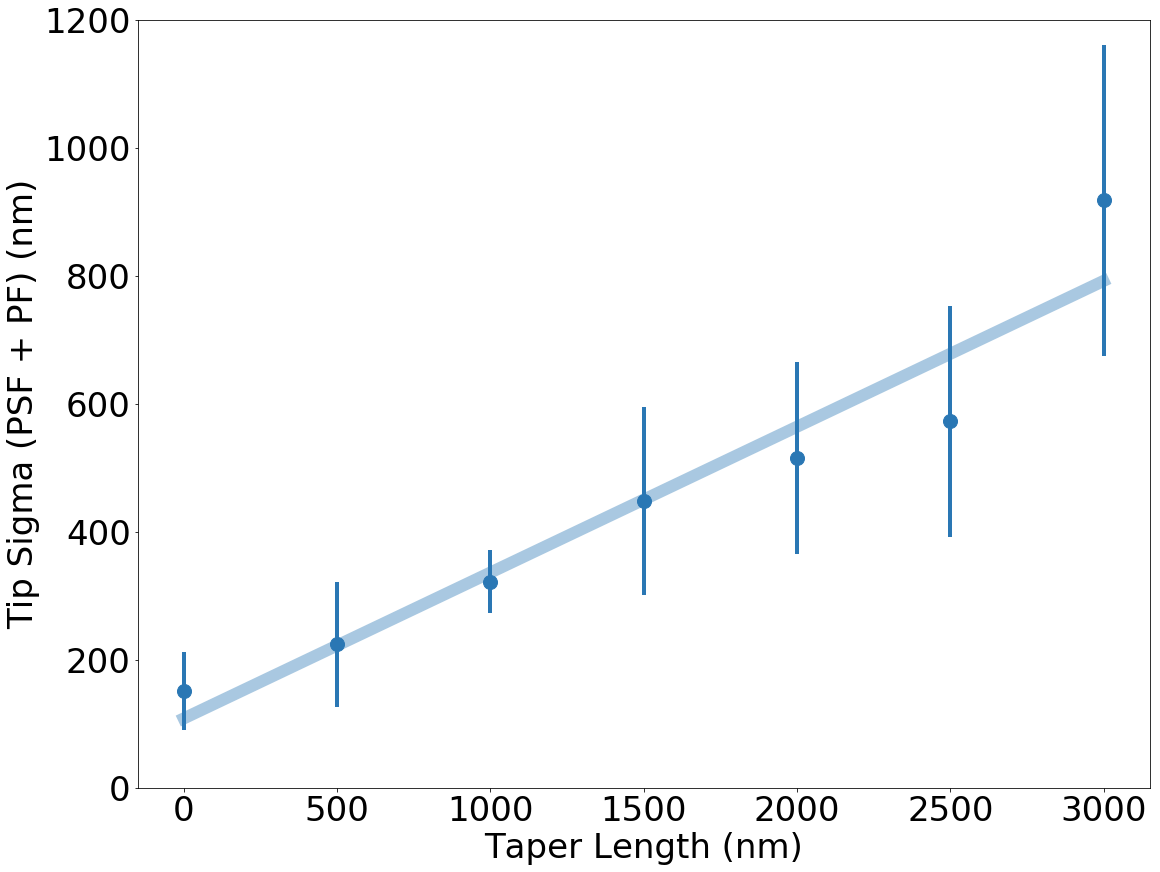

In [77]:
x_feature = 'condition'
y_feature = 'fitted_sigma_nm'

font_size = 34
color = "#2a77b4"

fig, ax = plt.subplots(figsize=(16, 12), constrained_layout=True)

x = data[x_feature]
y = data[y_feature]
#ax.scatter(x, y, alpha=0.4, marker='x')

gb = data.groupby(x_feature)
average = gb.mean()

x_average = average.index
y_average = average[y_feature]
ax.errorbar(x_average, y_average, yerr=gb.std()[y_feature], fmt='o', color=color, elinewidth=4, markersize=14)

# Fit the data
a, b = np.polyfit(x_average, y_average, deg=1)
x_fit = np.arange(x_average.min(), x_average.max(), 1)
y_fit = a * x_fit + b
ax.plot(x_fit, y_fit, color=color, lw=12, alpha=0.4)

ax.set_xlabel("Taper Length (nm)", fontsize=font_size)
ax.set_ylabel("Tip Sigma (PSF + PF) (nm)", fontsize=font_size)

ax.set_ylim(0, 3000)
ax.set_ylim(0, 1200)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    
fig.savefig(data_dir / "taper_length.png")